Implemented LDA using genism to find the optimal number of distinct topics from the data focused on experiences of people using invisalign expressed on reddit.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import sys
# !{sys.executable} -m spacy download en
import re, numpy as np, pandas as pd
from pprint import pprint

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

Path to folder with input file

In [ ]:
# Import Dataset
df = pd.read_excel('/content/drive/MyDrive/invisalignKeyword_content_separate.xlsx')
print(df.shape)  #> (2361, 3)
df.head()

(8960, 3)


SubmissionNumber   Subreddit  \
0                 1  invisalign   
1                 1         NaN   
2                 1         NaN   
3                 1         NaN   
4                 1         NaN   

                                             Content  
0  Did any of you ever get used to the feeling of...  
1  Yeah now Im worried about not being able to ha...  
2  Same! I dislike the feeling of the attachments...  
3  Im on tray 10 and I feel uncomfortable both in...  
4  Totally understanding the lip thing, it would ...

In [ ]:
data = df.Content.values.tolist()
print(type(data))
print(data)

<class 'list'>
['Did any of you ever get used to the feeling of the trays in your mouth, I never did throughout the entire process, I was uncomfortable and missed my braces.', 'Yeah now Im worried about not being able to handle not wearing them once Im finished …', 'Same! I dislike the feeling of the attachments when the trays are out.', 'Im on tray 10 and I feel uncomfortable both in and out lol. When theyre out my natural teeth feel strangely sharp and thin. And when theyre in, the trays feel bulky and make my lips protrude.', 'Totally understanding the lip thing, it would look like I was pouting and it felt really uncomfortable', 'i get the natural teeth being strangely thin lol. its sooo weird.', 'I am uncomfortable when I take them out. I love the softness of it and the fact that it stops me from grinding', 'omg it made me want to grind them when I had them on …', 'I cannot stop "sucking" on them as I type this and it is driving me nuts! I\'m on tray 8 at 2 weeks each. 7 more to g

Data cleaning

In [ ]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Convert to list
data = df.Content.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1])
# [['from', 'irwin', 'arnstein', 'subject', 're', 'recommendation', 'on', 'duc', 'summary', 'whats', 'it', 'worth', 'distribution', 'usa', 'expires', 'sat', 'may', 'gmt', ...trucated...]]

[['did', 'any', 'of', 'you', 'ever', 'get', 'used', 'to', 'the', 'feeling', 'of', 'the', 'trays', 'in', 'your', 'mouth', 'never', 'did', 'throughout', 'the', 'entire', 'process', 'was', 'uncomfortable', 'and', 'missed', 'my', 'braces']]


In [ ]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# !python3 -m spacy download en  # run in terminal once
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)  # processed Text Data!

In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)
print(id2word)

Dictionary<7300 unique tokens: ['brace', 'entire', 'ever', 'feeling', 'miss']...>


In [ ]:
# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]
print(corpus)

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1)], [(10, 1), (11, 1), (12, 1), (13, 1), (14, 1)], [(8, 1), (15, 1), (16, 1), (17, 1)], [(8, 2), (9, 1), (17, 3), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1)], [(9, 1), (17, 1), (19, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1)], [(20, 1), (21, 1), (24, 1), (25, 1), (26, 1), (33, 1), (34, 1)], [(9, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1)], [(36, 1), (40, 1)], [(39, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1)], [(17, 1), (43, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1)], [(27, 1), (52, 1), (53, 1), (54, 1)], [(8, 1), (43, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1)], [(5, 1), (52, 1), (58, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1)], [(8, 1), (44, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1)], [(17, 1), (31, 1), (74, 1), (75, 1), (76, 1)], [(20, 1), (51, 1), (77, 1), (78, 1), (79, 1), (80, 

In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=6, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

pprint(lda_model.print_topics())

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.075*"treatment" + 0.039*"year" + 0.039*"end" + 0.034*"insurance" + '
  '0.031*"total" + 0.030*"payment" + 0.024*"great" + 0.022*"orthodontist" + '
  '0.019*"definitely" + 0.019*"pretty"'),
 (1,
  '0.065*"week" + 0.053*"eat" + 0.045*"aligner" + 0.033*"people" + '
  '0.026*"water" + 0.024*"bite" + 0.022*"help" + 0.021*"sure" + 0.019*"clean" '
  '+ 0.019*"gum"'),
 (2,
  '0.113*"tooth" + 0.040*"feel" + 0.035*"mouth" + 0.033*"attachment" + '
  '0.032*"really" + 0.029*"look" + 0.025*"wear" + 0.023*"thing" + 0.020*"back" '
  '+ 0.020*"move"'),
 (3,
  '0.044*"dentist" + 0.035*"tooth" + 0.031*"normal" + 0.029*"remove" + '
  '0.029*"plan" + 0.023*"drink" + 0.021*"fine" + 0.017*"lol" + 0.015*"cause" + '
  '0.015*"appointment"'),
 (4,
  '0.104*"pay" + 0.026*"still" + 0.020*"maybe" + 0.018*"hour" + 0.016*"price" '
  '+ 0.016*"fit" + 0.015*"meal" + 0.015*"case" + 0.015*"experience" + '
  '0.014*"scan"'),
 (5,
  '0.089*"tray" + 0.055*"month" + 0.049*"invisalign" + 0.038*"day" + '
  '0.035*"

In [ ]:
!pip install pyLDAvis

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.9/dist-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.313449 -0.234465       1        1  29.076739
2      0.187937  0.216513       2        1  21.604138
1     -0.087942  0.030248       3        1  15.130935
0     -0.197545 -0.159674       4        1  12.637667
4     -0.166361 -0.096046       5        1  10.867013
3     -0.049539  0.243424       6        1  10.683508, topic_info=           Term         Freq        Total Category  logprob  loglift
26        tooth  4463.000000  4463.000000  Default  30.0000  30.0000
8          tray  4369.000000  4369.000000  Default  29.0000  29.0000
341         pay  1796.000000  1796.000000  Default  28.0000  28.0000
80        month  2548.000000  2548.000000  Default  27.0000  27.0000
123   treatment  1515.000000  1515.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
1230    bonding   145.865803   146.759459   Topic6  -4.7594   2.2304
662         jaw   137.263775   138.146512   Topic6  -4.8202   2.2301
1195     anyway   129.870659   130.757326   Topic6  -4.8756   2.2297
300        huge   128.809585   129.705766   Topic6  -4.8838   2.2295
26        tooth   589.569401  4463.771329   Topic6  -3.3627   0.2121

[230 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
10        2  0.996511    able
191       3  0.998988     add
403       5  0.993563  adjust
523       6  0.997258  advice
222       4  0.997558     ago
...     ...       ...     ...
90        1  0.999051    work
360       3  0.993318   worry
132       4  0.996170   worth
286       4  0.995232   wrong
124       4  0.998917    year

[215 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 3, 2, 1, 5, 4])

In [ ]:
def compute_coherence_values(dictionary,corpus,texts,start,limit,step):
    coherence_vals=[]
    model_list=[]
    
    for num_topics in range(start,limit,step):
        # building LDA Model
        model=gensim.models.ldamodel.LdaModel(corpus=corpus,id2word=dictionary,
                                              num_topics=num_topics,random_state=100,
                                              chunksize=100,passes=10,alpha='auto',per_word_topics=True)

        model_list.append(model)
        
        coherencemodel=CoherenceModel(model=model,texts=texts,dictionary=dictionary,coherence='c_v')
        
        coherence_vals.append(coherencemodel.get_coherence())
    return model_list,coherence_vals

In [ ]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_ready, start=1, limit=40, step=1)

In [ ]:
print(coherence_values)

[0.6291064128266566, 0.612135729359425, 0.6565001688207727, 0.6315287386718939, 0.5764860659799884, 0.5433167740071579, 0.44789409440661465, 0.48108819979118245, 0.4412238003130319, 0.44358379238416845, 0.4072315508679681, 0.4262371387743837, 0.42680100547288896, 0.3947066858676321, 0.40135079786083616, 0.3795192531260534, 0.370152731474266, 0.3802856976262327, 0.38911685029815796, 0.3617285214506163, 0.3647220036159812, 0.3646930160217861, 0.3499699422661917, 0.3518155797427765, 0.3611028372405884, 0.36562983412298994, 0.3470763043526002, 0.3706610498388842, 0.4557651471230995, 0.4849967102128067, 0.4978981839536815, 0.49716059671949925, 0.48571233850074635, 0.499842396820684, 0.486748190356902, 0.504014740528673, 0.5036125758013916, 0.49121257659976203, 0.5158656144556846]


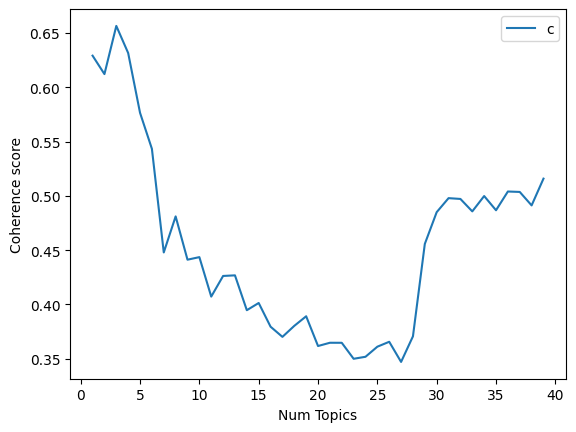

In [ ]:
# Show graph
limit=40; start=1; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=6, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

pprint(lda_model.print_topics())

[(0,
  '0.075*"treatment" + 0.039*"year" + 0.039*"end" + 0.034*"insurance" + '
  '0.031*"total" + 0.030*"payment" + 0.024*"great" + 0.022*"orthodontist" + '
  '0.019*"definitely" + 0.019*"pretty"'),
 (1,
  '0.065*"week" + 0.053*"eat" + 0.045*"aligner" + 0.033*"people" + '
  '0.026*"water" + 0.024*"bite" + 0.022*"help" + 0.021*"sure" + 0.019*"clean" '
  '+ 0.019*"gum"'),
 (2,
  '0.113*"tooth" + 0.040*"feel" + 0.035*"mouth" + 0.033*"attachment" + '
  '0.032*"really" + 0.029*"look" + 0.025*"wear" + 0.023*"thing" + 0.020*"back" '
  '+ 0.020*"move"'),
 (3,
  '0.044*"dentist" + 0.035*"tooth" + 0.031*"normal" + 0.029*"remove" + '
  '0.029*"plan" + 0.023*"drink" + 0.021*"fine" + 0.017*"lol" + 0.015*"cause" + '
  '0.015*"appointment"'),
 (4,
  '0.104*"pay" + 0.026*"still" + 0.020*"maybe" + 0.018*"hour" + 0.016*"price" '
  '+ 0.016*"fit" + 0.015*"meal" + 0.015*"case" + 0.015*"experience" + '
  '0.014*"scan"'),
 (5,
  '0.089*"tray" + 0.055*"month" + 0.049*"invisalign" + 0.038*"day" + '
  '0.035*"

In [ ]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
import matplotlib.colors as mcolors

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 6
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 6119 samples in 0.006s...
[t-SNE] Computed neighbors for 6119 samples in 0.454s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6119
[t-SNE] Computed conditional probabilities for sample 2000 / 6119
[t-SNE] Computed conditional probabilities for sample 3000 / 6119
[t-SNE] Computed conditional probabilities for sample 4000 / 6119
[t-SNE] Computed conditional probabilities for sample 5000 / 6119
[t-SNE] Computed conditional probabilities for sample 6000 / 6119
[t-SNE] Computed conditional probabilities for sample 6119 / 6119
[t-SNE] Mean sigma: 0.062874
[t-SNE] KL divergence after 250 iterations with early exaggeration: 77.724670
[t-SNE] KL divergence after 1000 iterations: 1.232700


In [ ]:
!pip install pyLDAvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 23.5 MB/s eta 0:00:00


In [ ]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.9/dist-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.313449 -0.234465       1        1  29.078043
2      0.187937  0.216513       2        1  21.603619
1     -0.087942  0.030248       3        1  15.130460
0     -0.197545 -0.159674       4        1  12.637676
4     -0.166361 -0.096046       5        1  10.867128
3     -0.049539  0.243424       6        1  10.683074, topic_info=           Term         Freq        Total Category  logprob  loglift
26        tooth  4463.000000  4463.000000  Default  30.0000  30.0000
8          tray  4369.000000  4369.000000  Default  29.0000  29.0000
341         pay  1796.000000  1796.000000  Default  28.0000  28.0000
80        month  2548.000000  2548.000000  Default  27.0000  27.0000
123   treatment  1515.000000  1515.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
1230    bonding   145.859880   146.753536   Topic6  -4.7594   2.2304
662         jaw   137.258202   138.140939   Topic6  -4.8202   2.2301
1195     anyway   129.865385   130.752053   Topic6  -4.8756   2.2297
300        huge   128.804355   129.700536   Topic6  -4.8838   2.2296
26        tooth   589.545462  4463.654271   Topic6  -3.3627   0.2121

[230 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
10        2  0.996534    able
191       3  0.996552     add
403       5  0.993552  adjust
523       6  0.997299  advice
222       4  0.997558     ago
...     ...       ...     ...
90        1  0.999007    work
360       3  0.993349   worry
132       4  0.996169   worth
286       4  0.995231   wrong
124       4  0.998916    year

[215 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 3, 2, 1, 5, 4])

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
